In [1]:
# Standard library
import os
import random
import time
import pickle

# Scientific computation
import numpy as np
from scipy import stats
from sklearn import metrics

# Network science
import networkx as nx
from cdlib import algorithms
from cdlib import evaluation

# Data handling and visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Miscellaneous
from tqdm import tqdm as tqdm  # Progress bars

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'karateclub', 'graph_tool', 'leidenalg', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


In [ ]:
def duplex_network (G, l1, l2, verbose=False):
    """Formats a duplex without inactive nodes or edge overlap.

    Parameters
    ----------
    G : dict
        Map from layer ids to corresponding graphs
    l1 : int
        Id of one of the layers in the resultant duplex
    l2 : int
        Id of the other layer in the resultant duplex
    verbose : bool, optional
        Indicator if verbose printing should be enabled, by default False

    Returns
    -------
    tuple
        Formatted layers of the resultant duplex
    """
    # >>> Book-keeping >>>
    # Create deepcopies of input networks
    G1 = G[l1].copy()
    G2 = G[l2].copy()
    # <<< Book-keeping <<<

    # >>> Duplex construction >>>
    # Remove edges common to both layers
    list_of_common_edges = []

    ## Identify common edges
    for edge in G[l1].edges():
        if G[l2].has_edge(edge[0], edge[1]):  # order safe for undirected networks
            list_of_common_edges.append([e[0], e[1]])

    ## Delete common edges from _both_ layers
    for e in list_of_common_edges:
        G1.remove_edge(e[0], e[1])
        G2.remove_edge(e[0], e[1])

    if verbose:
        print(f"Number of common edges removed: {len(list_of_common_edges)}")

    # Remove nodes with zero degree
    ## Identify nodes in one layer with no activity
    list_of_nodes = []
    for n in G1.nodes():
        if G1.degree(n)==0:
            list_of_nodes.append(n)

    ## Remove inactive nodes from one layer
    for n in list_of_nodes:
        G1.remove_node(n)
    if verbose:
        print(f"Number of inactive nodes removed from layer {l1}: {len(list_of_nodes)}")

    list_of_nodes = []
    ## Identify nodes in other layer with no activity
    for n in G2.nodes():
        if G2.degree(n)==0:
            list_of_nodes.append(n)
    ## Remove inactive nodes from one layer
    for n in list_of_nodes:
        G2.remove_node(n)
    if verbose:
        print(f"Number of inactive nodes removed from layer {l2}: {len(list_of_nodes)}")

    # Ensure node sets equivalent - Create union of nodes
    ## Identify nodes in either layer
    list_of_nodes = []
    for n in G1.nodes():
        list_of_nodes.append(n)
    for n in G2.nodes():
        list_of_nodes.append(n)
    if verbose:
        print(f"Size of active node set union from layers {l1} and {l2}: {len(list_of_nodes)}")
    ## Add nodes to both layers
    for n in list_of_nodes:
        G1.add_node(n)
        G2.add_node(n)
    # <<< Duplex construction <<<

    return G1, G2

In [2]:
def partial_information (G1, G2, frac):
    # >>> Book-keeping >>>
    LAYER_G1_ID = 1
    LAYER_G2_ID = 1 - LAYER_G1_ID
    Etest = {}  # unobserved edges, (edge) -> layer
    Etrain = {}  # observed edges, (edge) -> layer
    # <<< Book-keeping <<<

    # Observe `frac` proportion of edges from edge layer
    for e in G1.edges():
        if random.random() < frac:
            Etrain[e] = LAYER_G1_ID
        else:
            Etest[e] = LAYER_G1_ID
    for e in G2.edges():
        if random.random() < frac:
            Etrain[e] = LAYER_G2_ID
        else:
            Etest[e] = LAYER_G2_ID

    # Form remnant graphs
    ## Add nodes (union of both layers)
    rem_G1 = nx.Graph()
    rem_G2 = nx.Graph()
    for n in G1:
        rem_G1.add_node(n)
        rem_G2.add_node(n)
    for n in G2:
        rem_G1.add_node(n)
        rem_G2.add_node(n)

    # Add aggregate test edges
    for e in Etest:
        rem_G1.add_edge(e[0], e[1])
        rem_G2.add_edge(e[0], e[1])

    # Add observed edges to other remnant
    for e in Etrain:
        if Etrain[e] == LAYER_G1_ID:
            rem_G1.add_edge(e[0], e[1])
        if Etrain[e] == LAYER_G2_ID:
            rem_G2.add_edge(e[0], e[1])

    return rem_G1, rem_G2, Etest


In [ ]:
def community_finder (G):
    # >>> Book-keeping >>>
    sigma = {}
    c = 0

    # <<< Book-keeping <<<

    # >>> Community detection >>>
    # Apply community detection to network
    C = algorithms.louvain(G)

    # Form node -> community_id mapping
    for r in C.communities:
        for q in r:
            sigma[q] = c
        c = c + 1

    # Estimate community strength
    mu = tot = 0.0
    for n in G.nodes():
        for m in G.neighbors(n):
            tot += 1.0
            if sigma[n] == sigma[m]:
                mu += 1.0
    # <<< Community detection <<<

    return sigma, mu, tot


In [ ]:
def classifier (rem_G1, rem_G2, Etest, TT = 0, show_log = False):

    # >>> DC Classifier >>>
    if TT == 0:
        sigma1, mu1, tot1 = community_finder(rem_G1)
        sigma2, mu2, tot2 = community_finder(rem_G2)


        mu = 0.5
        if tot1 + tot2 > 0.0:
            mu = (mu1 + mu2) / (tot1 + tot2)

        classification, scores, ground_truth = [], [], []

        for e in Etest:
            n = e[0]
            m = e[1]

            s1 = rem_G1.degree(n)*rem_G1.degree(m)
            if sigma1[n] == sigma1[m]:
                s1 = s1 * mu
            else:
                s1 = s1 * (1.0-mu)

            s2 = rem_G2.degree(n)*rem_G2.degree(m)
            if sigma2[n] == sigma2[m]:
                s2 = s2 * mu
            else:
                s2 = s2 * (1.0-mu)

            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)

            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0

            if show_log == True:
                print (mu)
                print (rem_G1.degree(n), rem_G1.degree(m), t1)
                print (rem_G2.degree(n), rem_G2.degree(m), t2)
                print (Etest[e], '\n')

            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])

        return classification, scores, ground_truth
    # <<< DC Classifier <<<

    # >>> D Classifier >>>
    if TT == 1:
        classification, scores, ground_truth = [], [], []

        for e in Etest:
            n = e[0]
            m = e[1]

            s1 = rem_G1.degree(n)*rem_G1.degree(m)
            s2 = rem_G2.degree(n)*rem_G2.degree(m)

            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)

            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0

            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])

        return classification, scores, ground_truth
    # <<< D Classifier <<<

    # >>> C Classifier >>>
    if TT == 2:
        sigma1, mu1, tot1 = community_finder(rem_G1)
        sigma2, mu2, tot2 = community_finder(rem_G2)

        mu = 0.5
        if tot1 + tot2 > 0.0:
            mu = (mu1 + mu2) / (tot1 + tot2)

        classification, scores, ground_truth = [], [], []

        for e in Etest:
            n = e[0]
            m = e[1]

            s1 = 1.0
            if sigma1[n] == sigma1[m]:
                s1 = s1 * mu
            else:
                s1 = s1 * (1.0-mu)

            s2 = 1.0
            if sigma2[n] == sigma2[m]:
                s2 = s2 * mu
            else:
                s2 = s2 * (1.0-mu)

            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)

            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0

            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])

        return classification, scores, ground_truth
    # <<< C Classifier <<<


In [ ]:
def perform_analysis (G1, G2, step, TT = 0):

    # >>> Book-keeping >>>
    x , y, z  = [], [], []
    frac = 0.0
    # <<< Book-keeping <<<

    # >>> Sweep over relative size of training set >>>
    while frac < 1.0:
        if frac <= 1.0 - step:
            print ('# %.2f ' %frac, ' %.2f' %(1.0 - step))

            # Observe information
            rem_G1, rem_G2, Etest  = partial_information (G1, G2, frac)

            # Reconstruct multiplex
            classification, scores, ground_truth = classifier (rem_G1, rem_G2, Etest, TT)

            # Measure reconstruction performance
            acc = metrics.accuracy_score(ground_truth, classification)
            auc = metrics.roc_auc_score(ground_truth, scores)

            x.append(frac)
            y.append(acc)
            z.append(auc)

        frac += step
    # <<< Sweep over relative size of training set <<<

    results = [x, y, z]
    return results


In [3]:
def generate_power_law (gamma, kmin, kmax):
    """Generate a degree from a powerlaw distribution with exponent value gamma and bounds kmin, kmax.
    """
    xmin = np.power(kmin, 1.0 - gamma)
    xmax = np.power(kmax, 1.0 - gamma)
    x = xmax - random.random()*(xmax - xmin)
    x = np.power(x, 1.0 / (1.0 -gamma))
    return int(x)


In [ ]:

def control_correlation (degree, prob):

    # >>> Book-keeping >>>
    tmp_degree = []  # degrees after shuffling to destroy correlations
    # <<< Book-keeping <<<

    # >>> Modifying correlation >>>
    # Add each original degree sequence to list of degree sequences
    for i in range(len(degree)):
        tmp_degree.append(degree[i])

    # Swap degrees according to specified probability
    for i in range(len(tmp_degree)):
        if random.random()<prob:
            n = tmp_degree[i]
            j = random.randint(0, len(degree)-1)
            tmp_degree[i] = tmp_degree[j]
            tmp_degree[j] = n
    # <<< Modifying correlation <<<

    return tmp_degree


In [ ]:
def generate_configuration_model (degree):
    """Generate a single instance of the configuration model with the specified degree sequence.

    Note that this function exclusively generates undirected and unweighted networks.

    Parameters
    ----------
    degree : list
        Desired degree sequence.

    Returns
    -------
    nx.Graph
        Resultant configuration model sample.
    """

    # >>> Book-keeping >>>
    G = nx.Graph()  # instantiate correctly sized graph
    for n in range(0, len(degree)):
        G.add_node(n)
    edges = []  # edges to add
    # <<< Book-keeping <<<

    # >>> Constructing graph >>>
    # Initialize edges
    for i in range(0, len(degree)):
        k = degree[i]
        for j in range(0, k):
            edges.append(i)

    # Identifying edges with configuration model
    for i in range(0, len(edges)):
        j = random.randint(0, len(edges)-1)
        tmp = edges[i]
        edges[i] = edges[j]
        edges[j] = tmp

    # Adding edges to graph
    for i in range(0, len(edges)-1, 2):
        n = edges[i]
        m = edges[i+1]
        if G.has_edge(n, m) == False and n != m:
            G.add_edge(n, m)
    # <<< Constructing graph <<<

    return G


In [ ]:
def generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign):
    """Generate a two-layer multiplex with configuration model layers.

    Parameters
    ----------
    N : int
        Number of nodes
    gamma : float
        Degree sequence exponent. Positive as a parameter.
    kmin : float
        Minimum degree.
    kmax : float
        Maximum degree.
    prob : float
        Proportion of edges to shuffle from one layer to the second.
    sign : int
        Sort of degree sequence when creating second layer. Must be -1 or 1. -1 corresponds to anti-correlated, 1 to correlated.

    Returns
    -------
    dict
        Mapping of layer ids to layers. Default keys 1 and 2.
    """

    # >>> Book-keeping >>>
    degree = []  # layer one degree sequence
    tmp_degree = []  # layer two degree sequence
    G = {}  # dictionary of layers
    # <<< Book-keeping <<<

    # >>> Multiplex construction >>>
    # Sample layer one degree sequence
    for i in range(0, N):
        degree.append(generate_power_law (gamma, kmin, kmax))
    degree = sorted(degree)

    # Construct layer two degree sequence with specified (anti)correlation
    for i in range (0, len(degree)):
        if sign > 0:
            tmp_degree.append(degree[i])
        if sign < 0:
            tmp_degree.append(degree[len(degree)-i-1])
    tmp_degree = control_correlation (tmp_degree, prob)

    # Build layers from degree sequences
    G[1] = generate_configuration_model (degree)
    G[2] = generate_configuration_model (tmp_degree)
    # <<< Multiplex construction <<<

    return G

In [4]:
def LFR(n,t1,t2,mu,avg_k,max_k,min_community):
    #function to generate LFR network as a networkx object and obtain community assignments

    # >>> Book-keeping >>>
    # Cast parameters as strings
    N = str(n)
    Mu = str(mu)
    T1 = str(t1)
    T2 = str(t2)
    maxk = str(max_k)
    k = str(avg_k)
    min_community = str(min_community)

    # Concatenate LFR binary shell command as a string
    s='./benchmark -N '+N+' -mu '+Mu+ ' -maxk ' +maxk  + ' -k '+k  +' -t1 ' +T1+' -t2 ' +T2 # +' -minc ' +min_community
    # <<< Book-keeping <<<


    # >>> LFR generation >>>
    # Call LFR binary and generate networks
    os.system(s)

    # Format resultant network as networkx Graph
    x=np.loadtxt('network.dat')
    edges=[(int(x[i][0])-1,int(x[i][1])-1) for i in range(len(x))]
    g=nx.Graph(edges)

    # Format resultant node partition as dict
    x=np.loadtxt('community.dat')
    coms={int(x[i][0])-1:int(x[i][1]) for i in range(len(x))}
    # <<< LFR generation <<<

    return g, coms


In [ ]:
def lfr_multiplex (N, tau1, tau2, mu, average_degree, max_degree, min_community, prob_relabel):

    # >>> Book-keeping >>>
    groups = {}
    # <<< Book-keeping <<<

    # >>> Experimental data sampling >>>
    # Generate LFR network (one layer)
    H, comm = LFR(n=N, t1=tau1, t2=tau2, mu=mu, avg_k=average_degree, max_k = max_degree, min_community=min_community)

    # Create list of communities
    for n in comm:
        c = comm[n]
        if c not in groups:
            groups[c] = []
        groups[c].append(n)


    # Create node -> community mapping
    sigma1 = {}
    for n in comm:
        sigma1[n] = comm[n]


    # Shuffle community labels
    new_labels = {}  # old_community_label -> new_community_label
    for C in groups:
        tmp = groups[C].copy()
        random.shuffle(tmp)
        for i in range(0, len(groups[C])):
            n = groups[C][i]
            m = tmp[i]
            new_labels[n] = m

    # Apply community label shuffling to node -> community mapping
    tmp_sigma2 = {}
    for n in sigma1:
        m = new_labels[n]
        tmp_sigma2[m] = sigma1[n]

    # Form duplex of LFR layers
    G = {}
    G[1] = H.copy()
    G[2] = nx.Graph()

    ## Ensure same node set in both layers
    for n in G[1]:
        G[2].add_node(n)

    ## Add edges to second layer _with label shuffling_
    for e in G[1].edges():
        n = new_labels[e[0]]
        m = new_labels[e[1]]
        G[2].add_edge(n, m)

    # Beak community correlation between layers
    list_nodes = list(G[2].nodes())
    new_labels = {}
    H = G[2].copy()
    for n in G[2]:
        new_labels[n] = n
    for n in new_labels:
        if random.random()<prob_relabel:
            m = random.choice(list_nodes)
            tmp = new_labels[n]
            new_labels[n] = new_labels[m]
            new_labels[m] = tmp

    G[2] = nx.Graph()
    for n in H:
        m = new_labels[n]
        G[2].add_node(m)
    for e in H.edges():
        n = new_labels[e[0]]
        m = new_labels[e[1]]
        G[2].add_edge(n, m)

    sigma2 = {}
    for n in tmp_sigma2:
        m = new_labels[n]
        sigma2[m] = tmp_sigma2[n]
    # <<< Experimental data sampling <<<

    return G, sigma1, sigma2, mu


## Figure 3 (LFR)

In [6]:
tau2 = 1.0
gamma = 2.1
min_community = 1
prob = 1.0
mu = 0.1
step = 0.1
average_degree = 5.0
frac = 0.5


results_lfr = {}

In [9]:
for rN in np.logspace(3, 5, 10):

    N = int(rN)
    max_degree = int(np.sqrt(N))


    G, sigma1, sigma2, mu_tmp = lfr_multiplex (N, gamma, tau2, mu, average_degree, max_degree, min_community, prob)
    
    print ('\n\n#Network generated')
    
    l1 = 1
    l2 = 2
    G1, G2 = duplex_network (G, l1, l2)
    
    rem_G1, rem_G2, Etest  = partial_information (G1, G2, frac)
    
    timer = time.perf_counter()
    classification, scores, ground_truth = classifier (rem_G1, rem_G2, Etest, TT=0)
    Deltat = time.perf_counter() - timer
    print(f"{N},{Deltat}")
    
    
    results_lfr[N] = Deltat



#Network generated
9
1000,0.23401636350899935


#Network generated
10
1668,0.4243497345596552


#Network generated
16
2782,0.7449532011523843


#Network generated
14
4641,1.482868048362434


#Network generated
18
7742,2.529793843626976


#Network generated
17
12915,4.8238986153155565


#Network generated
10
21544,9.423687781207263


#Network generated
13
35938,18.486426878720522


#Network generated
30
59948,34.45769833680242


OSError: network.dat not found.

In [10]:
with open('figure3a_data.pk', 'wb') as handle:
    pickle.dump(results_lfr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('figure3a_data.pk', 'rb') as handle:
    results_lfr = pickle.load(handle)

alpha :  -9.95156339477742
beta :  1.2229288952597022
correlation coefficient :  0.999658660148718


Text(0, 0.5, 'Computational time')

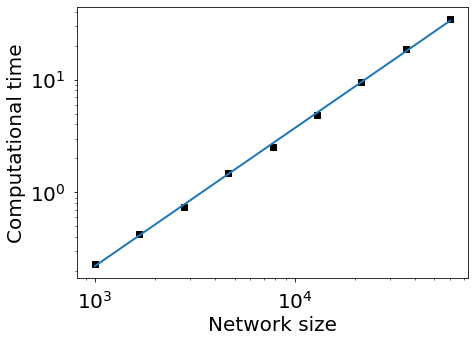

In [13]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



x , y = [], []
for N in results_lfr:
    x.append(N)
    y.append(results_lfr[N])
    
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x),np.log(y))
print ('alpha : ', intercept)
print ('beta : ', slope)
print ('correlation coefficient : ', r_value)


plt.plot(x, y, marker='s', linewidth=0, color = 'black')
plt.plot(x, np.exp(intercept)*np.power(x,slope), marker='o', markersize=0, linewidth=2)





plt.xscale('log')
plt.yscale('log')

# plt.legend(loc='lower right', fontsize = 16)
plt.xlabel('Network size')
plt.ylabel('Computational time')
# plt.ylim(.0,1)
# plt.xlim(.0,1)

## Figure 3 (LFR)

In [17]:
gamma = 2.1
prob = 1.0
sign = 1
step = 0.1
kmin = 3


results = {}

In [18]:
for rN in np.logspace(3, 5, 10):

    N = int(rN)
    kmax = int(np.sqrt(N))


    G = generate_multiplex_configuration (N, gamma, kmin, kmax, prob, sign)
    
    print ('\n\n#Network generated')
    
    l1 = 1
    l2 = 2
    G1, G2 = duplex_network (G, l1, l2)
    
    rem_G1, rem_G2, Etest  = partial_information (G1, G2, frac)
    
    timer = time.perf_counter()
    classification, scores, ground_truth = classifier (rem_G1, rem_G2, Etest, TT=0)
    Deltat = time.perf_counter() - timer
    print(f"{N},{Deltat}")
    
    
    results[N] = Deltat



#Network generated
25
1000,1.026208769530058


#Network generated
27
1668,1.2027058955281973


#Network generated
43
2782,2.0937113985419273


#Network generated
44
4641,4.228177570737898


#Network generated
41
7742,8.322493329644203


#Network generated
50
12915,9.635865510441363


#Network generated
45
21544,19.722023578360677


#Network generated
62
35938,37.64889983739704


#Network generated
64
59948,64.4188712304458


#Network generated
75
100000,144.41821381822228


In [20]:
with open('figure3b_data.pk', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
with open('figure3b_data.pk', 'rb') as handle:
    results = pickle.load(handle)

alpha :  -7.740171903001517
beta :  1.0849335049191149
correlation coefficient :  0.9949770643894549


Text(0, 0.5, 'Computational time')

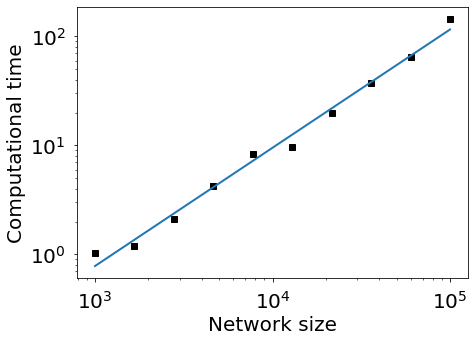

In [22]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8



x , y = [], []
for N in results:
    x.append(N)
    y.append(results[N])
    
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x),np.log(y))
print ('alpha : ', intercept)
print ('beta : ', slope)
print ('correlation coefficient : ', r_value)


plt.plot(x, y, marker='s', linewidth=0, color = 'black')
plt.plot(x, np.exp(intercept)*np.power(x,slope), marker='o', markersize=0, linewidth=2)





plt.xscale('log')
plt.yscale('log')

# plt.legend(loc='lower right', fontsize = 16)
plt.xlabel('Network size')
plt.ylabel('Computational time')
# plt.ylim(.0,1)
# plt.xlim(.0,1)